<h1><center>Computer Vision</center></h1>

<h2>Introduction</h2>

What is more exciting than seeing the world? To be able to see the best around us? The beauty of a sunset, the memorable waterfalls, or the seas of ice? Nothing would be possible if evolution hadn't endowed us with eyes. 

We recognize things because we have learned the shape of objects, we have learned to estimate that shape different from those we have encountered can be associated with the same object. We have learned by experience and because we were given the names of said objects. Like a supervised algorithm that needs a label to associate the shape, details, colors with a category. A dog and a wolf are very similar just across the pixels. Computer vision methods have enabled machines to be able to decipher these shapes and "learn" to classify them given to them.

Now, algorithms, just like our eyes can identify in pictures or films, objects, or shapes. The methods are constantly evolving and perfecting to the point of reaching the so-called human level. But, there are several methods, image classification, object detection or recognition, and image segmentation. In this article, we will explore the image classification problem. The first part will present training from scratch, the second will present training with data augmentation, and the last transfer learning with pre-trained models.

<h2>Data</h2>

We are going to use one image dataset. To avoid the classic MNIST[5] or FashionMNIST[6] for classification, we will take the dataset provided by INTEL (available on Kaggle[1]). These data are more fancies, they represent scenes from all over the world and contained in 6 classes (buildings, forest, mountain, glacier, sea, and street). The data volume is also accessible for a project on a local computer because the training set is made up of 14k images, the validation set contains 3k images and 7k for the test.

In [1]:
%matplotlib inline
import os
import pathlib
import PIL
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from glob import glob
from tqdm import tqdm
tqdm().pandas()
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array

0it [00:00, ?it/s]
/home/chris/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


<h4>Load the data</h4>

In [2]:
# creating paths to retrieve the data
ROOT = "/mnt/d"
FOLDER = "INTEL_images_classification"
TRAIN = os.path.join(ROOT, FOLDER, 'seg_train/seg_train')
TEST = os.path.join(ROOT, FOLDER, 'seg_test/seg_test')
PRED  = os.path.join(ROOT, FOLDER, 'seg_pred/seg_pred')

In [3]:
# save the path to the train data
data_dir = pathlib.Path(TRAIN)
test_dir = pathlib.Path(TEST)

In [4]:
data_dir

PosixPath('/mnt/d/INTEL_images_classification/seg_train/seg_train')

In [5]:
# count the number of images in the train
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"The number of images contained in the train set is {image_count}")

The number of images contained in the train set is 14034


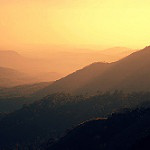

In [6]:
# Show one mountain
mountain = list(data_dir.glob('mountain/*'))
PIL.Image.open(str(mountain[0]))

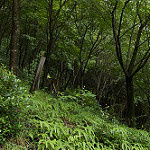

In [7]:
# Show one forest
forest = list(data_dir.glob('forest/*'))
PIL.Image.open(str(forest[0]))

In [8]:
def prepare_dataset(path,label):
    x_train=[]
    y_train=[]
    all_images_path=glob(path+'/*.jpg')
    for img_path in tqdm(all_images_path) :
            img=load_img(img_path, target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            x_train.append(img)
            y_train.append(label)
    return x_train,y_train

In [9]:
# Train dataset
labels = os.listdir(TRAIN)
x = []
y = []
for label in labels:
    x_, y_ = prepare_dataset(os.path.join(TRAIN, label), label)
    x.extend(x_)
    y.extend(y_)
x = np.array(x)
y = np.array(y)

labels = os.listdir(TEST)
x_test = []
y_test = []
for label in labels:
    x_, y_ = prepare_dataset(os.path.join(TEST, label), label)
    x_test.extend(x_)
    y_test.extend(y_)
x_test = np.array(x_test)
y_test = np.array(y_test)

100%|██████████| 501/501 [00:06<00:00, 79.89it/s]


In [10]:
# create a validation set 
from sklearn.model_selection import train_test_split
train_x, valid_x, y_train, y_valid = train_test_split(x, y, random_state=42, stratify=y, test_size=0.2)

In [11]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_train)
valid_y = encoder.transform(y_valid)
test_y  = encoder.transform(y_test)

In [12]:
len(train_x), len(valid_x), len(train_y), len(valid_y )

(11227, 2807, 11227, 2807)

<h4>Ploting Learning Curves</h4>

It's very important when training a deep learning model to see the behavior of the learning curves to determine if the model as bias, overfit, or normal behavior. To do it let's see the code below which permits to plot of the accuracy and losses curves for the training set and the evaluation set.

In [13]:
def plot_learning_curve(history, name):
    '''
    Function to plot the accuracy curve
    @param history: (history object) containing all the relevant information about the training
    @param name: (string) name of the model
    '''
    # extract informations 
    acc     = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss    = history.history["loss"] 
    val_loss= history.history["val_loss"] 
    epochs  = range(1, len(acc)+1)
    # plot accuracy
    plt.plot(epochs, acc, 'b-o', label='Training loss')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig(name+"_accuracy.png") # save the picture, put into comment if you don't want
    plt.figure()
    # plot losses
    plt.plot(epochs, loss, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(name+"_losses.png") # save the picture, put into comment if you don't want
    plt.show() 

<h4>Metrics</h4>

To evaluate classification models different metrics can be used such as accuracy, precision, recall, etc. (details of these metrics can be found <a href="https://towardsdatascience.com/model-selection-in-text-classification-ac13eedf6146">here</a>). The code below shows how to set up a metrics dictionary and the function that will be used to evaluate neural networks.

In [14]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [15]:
# Functions to extract the true, false positive and true false negative
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [16]:
score_metrics = {'acc': accuracy_score,
               'balanced_accuracy': balanced_accuracy_score,
               'prec': precision_score,
               'recall': recall_score,
               'f1-score': f1_score,
               'tp': tp, 'tn': tn,
               'fp': fp, 'fn': fn,
               'cohens_kappa':cohen_kappa_score,
               'matthews_corrcoef':matthews_corrcoef,
               "roc_auc":roc_auc_score}

In [17]:
def metrics_evaluation(y_test, y_pred, dic_score=score_metrics):
    '''
    @param y_test: (numpy array) true labels
    @param y_pred: (numpy array) predicted labels
    @param dic_score: (dict) dictionary containing the metrics for the evaluation
    '''
    
    scorer = {}
    for i in dic_score.keys(): 
        scorer[i] = None
        # metrics can be used for binary and multiclass classification problem
        if len(set(y_test))>2:
            if i in ["prec", "recall", "f1-score"]:
                
                scorer[i] = round(dic_score[i](y_test, np.argmax(y_pred,axis=1), average = 'weighted'),4) # make each function scorer

            elif i=="roc_auc":
                scorer[i] = round(dic_score[i](to_categorical(y_test), y_pred, average = 'macro', multi_class="ovo"),4 )# make each function scorer
            else:
                scorer[i] = round(dic_score[i]( y_test, np.argmax(y_pred,axis=1)),4) # make each function scorer

        else:
            scorer[i] = round(100*dic_score[i]( y_test, y_pred),2)
        
    return scorer

<h2>Methods</h2>

<h3>CNN From scratch</h3>

Image classification can, when the volume of data you have is large enough, be done "from scratch". The idea is to create a model from scratch that you will train completely.

So you are going to build a CNN and train it with this data. You'll add a convolutional layer then a pooling layer, maybe a dropout layer to decrease the risk of overfitting and finishing with dense fully connected layers. The last one will output the results, or the prediction, The number of unit in this last layer is the number of classes you want to predict.

In [61]:
# initialize values to store the results 
dict_hist = {}
df_results = pd.DataFrame()

In [29]:
num_classes = 6

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [40]:
es = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit(
  train_x,train_y,
  validation_data=(valid_x, valid_y), callbacks=[es], batch_size=32,
   epochs=30
)
dict_hist["from_scratch"] = history

Epoch 1/30
351/351 [==============================] - 536s 2s/step - loss: 1.1578 - accuracy: 0.5443 - val_loss: 1.0311 - val_accuracy: 0.6138
Epoch 2/30
351/351 [==============================] - 521s 1s/step - loss: 0.7857 - accuracy: 0.7071 - val_loss: 0.8440 - val_accuracy: 0.6776
Epoch 3/30
351/351 [==============================] - 517s 1s/step - loss: 0.6507 - accuracy: 0.7610 - val_loss: 0.7092 - val_accuracy: 0.7610
Epoch 4/30
351/351 [==============================] - 537s 2s/step - loss: 0.5608 - accuracy: 0.7943 - val_loss: 0.6575 - val_accuracy: 0.7610
Epoch 5/30
351/351 [==============================] - 572s 2s/step - loss: 0.5029 - accuracy: 0.8175 - val_loss: 0.6491 - val_accuracy: 0.7777
Epoch 6/30
351/351 [==============================] - 617s 2s/step - loss: 0.4358 - accuracy: 0.8393 - val_loss: 0.6170 - val_accuracy: 0.7870
Epoch 7/30
351/351 [==============================] - 624s 2s/step - loss: 0.3922 - accuracy: 0.8566 - val_loss: 0.6065 - val_accuracy: 0.7941

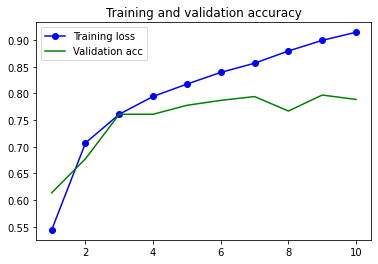

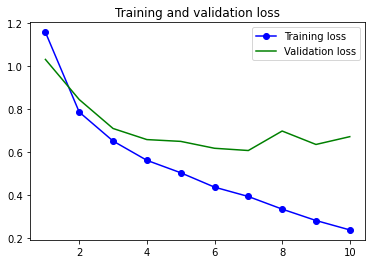

In [69]:
plot_learning_curve(history, "image_classif_from_scratch")

In [46]:
y_pred = model.predict(x_test)

In [68]:
df_results = df_results.append(pd.DataFrame(metrics_evaluation(test_y, y_pred, dic_score=score_metrics)))

{'acc': 0.7833333333333333,
 'balanced_accuracy': 0.7843867058121887,
 'prec': 78.94,
 'recall': 78.33,
 'f1-score': 78.31,
 'tp': 451,
 'tn': 306,
 'fp': 7,
 'fn': 1,
 'cohens_kappa': 0.7396810572313198,
 'matthews_corrcoef': 0.7410120598872408,
 'roc_auc': 93.37}

<h3>Data augmentation</h3>

So, if your model can't obtain a good performance. You can change the architecture of your network. You can add or delete the hidden layers, you can decrease or increase the number of units per layer. You can change the activation function. Or, you can change the preprocessing or your data. 

But, what to do if it's not enough? 

You can use data augmentation. This technique permits you to create artificially (synthetic) images from yours in memory (your original data will not be affected by this method). It consists of operations like rotation, the same picture will be rotated by different angles (creation of new images). Shifted, that is to say, that the pattern of the image will be offset from the frame, thus creating a "hole" which will have to be interpolated. This operation can be done horizontally or vertically. Zooming, the new image will be a zoom of a part in the original data, etc…

The perfect tool to do this is the object named ImageDataGenerator provided by Keras[2] (keras.preprocessing.image.ImageDataGenerator()).

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
data_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)

In [21]:
train_data_gen = data_gen.flow_from_directory(
                                        
                                        batch_size=100,
                                        directory=TRAIN,
                                        shuffle=True,
                                        target_size=(150, 150),
                                        class_mode='categorical'
                                        )
test_data_gen = test_gen.flow_from_directory(
                                        batch_size=32,
                                        directory=TEST,
                                        shuffle=True,
                                        target_size=(150, 150),
                                        class_mode='categorical'
                                        )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [57]:
num_classes = 6

model = tf.keras.Sequential([
    #data_augmentation,
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.5),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.3),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dropout(0.5),  
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
])
model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [58]:
es = tf.keras.callbacks.EarlyStopping(patience=3)
history2 = model.fit(
  train_data_gen,
    steps_per_epoch=2000 // 32,
  validation_data=test_data_gen, callbacks=[es], validation_steps=800 // 32,
   epochs=50
)


Epoch 1/50
62/62 [==============================] - 1116s 18s/step - loss: 2.0628 - accuracy: 0.1857 - val_loss: 1.7963 - val_accuracy: 0.1925
Epoch 2/50
62/62 [==============================] - 921s 15s/step - loss: 1.4567 - accuracy: 0.4090 - val_loss: 1.1994 - val_accuracy: 0.5300
Epoch 3/50
62/62 [==============================] - 916s 15s/step - loss: 1.2850 - accuracy: 0.4945 - val_loss: 1.1949 - val_accuracy: 0.5225
Epoch 4/50
62/62 [==============================] - 899s 14s/step - loss: 1.1684 - accuracy: 0.5349 - val_loss: 1.1282 - val_accuracy: 0.5263
Epoch 5/50
62/62 [==============================] - 911s 15s/step - loss: 1.1748 - accuracy: 0.5153 - val_loss: 1.0444 - val_accuracy: 0.5688
Epoch 6/50
62/62 [==============================] - 897s 14s/step - loss: 1.1001 - accuracy: 0.5558 - val_loss: 1.0204 - val_accuracy: 0.5788
Epoch 7/50
62/62 [==============================] - 899s 14s/step - loss: 1.0799 - accuracy: 0.5608 - val_loss: 0.9895 - val_accuracy: 0.5950
Epoch

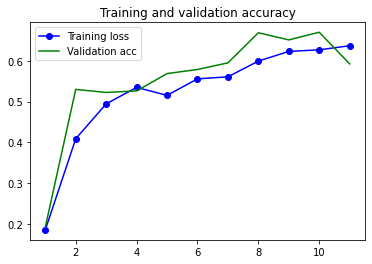

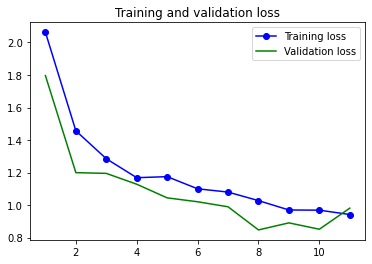

In [59]:
plot_learning_curve(history2, "image_classif_data_augmentation")

In [60]:
y_pred = model.predict(x_test)

In [61]:
metrics = metrics_evaluation(test_y, y_pred, dic_score=score_metrics)
results = pd.DataFrame(metrics.values(), index=metrics.keys()).T
results["Name"] = "Data_Augmentation"
#df_results = df_results.append(results) 
#dict_hist["data_augmentation"] = history2
results

,acc,balanced_accuracy,prec,recall,f1-score,tp,tn,fp,fn,cohens_kappa,matthews_corrcoef,roc_auc,Name
0,0.600667,0.59603,0.6525,0.6007,0.5761,463.0,168.0,90.0,0.0,0.51939,0.535064,0.9272,Data_Augmentation


<h3>Transfer Learning</h3>

No, this is not the time to run away afraid of transfer learning. What is transfer learning? It is simply a matter of using the knowledge learned for one task and exporting it to another.

In our case, transfer learning takes place with fairly large models (with millions or even hundreds of millions of parameters) that have been trained on a gigantic volume of data (the Imagenet[4] dataset) to generalize.

When you have a small dataset, the models you can build cannot represent patterns well. You must therefore use pre-trained models that you will then specialize with your data.

The method is simple, it is necessary to recover the pre-trained model(s), to freeze the weights of their layers. Leave only the last layer, or the last layers to then train them with your data.

Neural networks specialize more and more according to their depth. The first layers will detect general patterns, lines for example. Then shapes will appear until you reach very fine details in the last layers. These are the ones that must be used to "tune" the model to your data. So rather than retraining the complete model with the ImageNet dataset plus your data (which would take months and require a significant investment of money) you can in minutes/hours obtain an extremely performing model using transfer learning.

In [41]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import Xception, VGG16, VGG19, ResNet50V2, ResNet101V2, ResNet152V2, InceptionResNetV2, MobileNetV2, DenseNet121, DenseNet169, DenseNet201, EfficientNetB0, EfficientNetB4, EfficientNetB7, NASNetLarge

In [42]:
def pretrained_model_classification(x_train, y_train, x_valid, y_valid, x_test, y_test,  _model, batch_size=32, epochs_num=100, patience=3, num_classes=6):
    '''
    This function create a new model using transfer learning, train the model and evaluate it. 
    @param x_train: (numpy array, matrix) matrix containing pixels values of the train set
    @param y_train: (numpy array) list of label (int values) for the train set
    @param x_valid: (numpy array, matrix) matrix containing pixels values of the validation set
    @param y_valid: (numpy array) list of label (int values) for the validation set
    @param x_test: (numpy array, matrix) matrix containing pixels values of the test set
    @param y_test: (numpy array) list of label (int values) for the test set
    @param _model: (model) pretrained model 
    @param batch_size: (int) number of images for each batch default 32
    @param epochs_num: (int) number of epochs for the fit() default 100
    @param patience: (int) number of iteration without learning to break the training default 3
    @return history: (history object) containing the information of the training process
    @return results: (dataframe) pandas dataframe containing the metrics of the model evaluated on the test set
    '''
    # create an instance of the pretrained model
    base_model = _model
    # freeze the layers of the pretrained model
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)                  
    x = layers.Dense(6, activation='softmax')(x)           
    # create a new model with pretrained + last new layers
    model_final = Model(base_model.input, x) 
    # compile 
    model_final.compile(optimizer = 'adam', 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    # fit the model with early stopping
    es = tf.keras.callbacks.EarlyStopping(patience=patience)
    history = model_final.fit(
                  x_train, y_train,
                  validation_data=(x_valid, y_valid), callbacks=[es], epochs=epochs_num, batch_size=batch_size)
    # predict the test
    y_pred = model_final.predict(x_test)
    # evaluate the results on the test set
    metrics = metrics_evaluation(y_test, y_pred, dic_score=score_metrics)
    results = pd.DataFrame(metrics.values(), index=metrics.keys()).T
    
    return history, results


In [47]:
list_pretrained = [ InceptionV3, VGG16, VGG19] # Xception, ResNet50V2, ResNet101V2, ResNet152V2, InceptionResNetV2, 
                    #MobileNetV2, DenseNet121, DenseNet169, DenseNet201, EfficientNetB0, EfficientNetB4, EfficientNetB7, NASNetLarge,

for model in list_pretrained:
    name = model.__name__
    _hists, _df = pretrained_model_classification(train_x, train_y, valid_x, valid_y, x_test, test_y,
                                    _model=model(weights='imagenet', include_top=False, input_shape=(150, 150, 3)), 
                                    batch_size=32, epochs_num=30, patience=1, num_classes=6)
    #print(f"Model {name} done with accuracy: {100*_df['acc']}%, precision: {100*_df['prec']}%")
    dict_hist[name] = _hists
    _df["Name"] = name
    print(_df)
    df_results = df_results.append(_df)
    df_results.to_csv("results_pretrained.csv", sep=";", index = False)

Epoch 1/30
351/351 [==============================] - 746s 2s/step - loss: 0.5302 - accuracy: 0.8364 - val_loss: 0.3310 - val_accuracy: 0.8821
Epoch 2/30
351/351 [==============================] - 587s 2s/step - loss: 0.3019 - accuracy: 0.8888 - val_loss: 0.3834 - val_accuracy: 0.8636
        acc  balanced_accuracy    prec  recall  f1-score     tp     tn   fp  \
0  0.883667           0.887023  0.8881  0.8837    0.8824  465.0  413.0  2.0   

    fn  cohens_kappa  matthews_corrcoef  roc_auc         Name  
0  1.0      0.860312           0.861627   0.9882  InceptionV3  
Epoch 1/30
351/351 [==============================] - 4042s 12s/step - loss: 0.5249 - accuracy: 0.8073 - val_loss: 0.4169 - val_accuracy: 0.8447
Epoch 2/30
351/351 [==============================] - 3650s 10s/step - loss: 0.3870 - accuracy: 0.8578 - val_loss: 0.4838 - val_accuracy: 0.8016
     acc  balanced_accuracy    prec  recall  f1-score     tp     tn   fp   fn  \
0  0.795           0.804665  0.8453   0.795    0.7903  4

<h2>Results</h2>

In [ ]:
df_results

<h2>Discussion</h2>

The data augmentation method is the most delicate, the results are not those expected. The complexity of the model is to be tuned in order to increase the performance. The implementation of from scratch and transfer learning methods are by far the easiest to set up.

<h2>Conclusion</h2>

The pre-trained models with the transfer learning method allow us to obtain the best results on the data set.

The "from scratch" and data augmentation methods have shown interesting results but do not surpass transfer learning.

<h2>References</h2>

[1] https://www.kaggle.com/puneet6060/intel-image-classification 

[2] keras.io 

[3] Pratt, L. Y. (1993). "Discriminability-based transfer between neural networks" (PDF). NIPS Conference: Advances in Neural Information Processing Systems 5. Morgan Kaufmann Publishers. pp. 204–211.

[4] Olga Russakovsky et al. "ImageNet Large Scale Visual Recognition Challenge". IJCV, 2015.

[5] LeCun, Y. et al., 1998. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278–2324

[6] Han X., Kashif R., and Roland V., 2017. Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms arXiv preprint

[7] Chollet F., 2016. Xception: Deep Learning with Depthwise Separable Convolutions arXiv preprint 

[8] Simonyan K. and Zisserman A., 2014. Very Deep Convolutional Networks for Large-Scale Image Recognition arXiv preprint

[9] Szegedy C. et al., 2016. Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning arXiv preprint

[10] Sandler M. et al., 2019. MobileNetV2: Inverted Residuals and Linear Bottlenecks arXiv preprint

[11] Zoph B. et al., 2018. Learning Transferable Architectures for Scalable Image Recognition arXiv preprint 

[12] He K. et al., 2016. Deep Residual Learning for Image Recognition arXiv preprint

[13] Huang G. et al., 2017. Densely Connected Convolutional Networks arXiv preprint

[14] Tan M. and Le Q. V., 2019. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks arXiv preprint

[15] Szegedy C. et al., 2016. Rethinking the Inception Architecture for Computer Vision arXiv preprint